# Remake Graphical Abstract

Author: Jacob Parres-Gold (jparresau@caltech.edu)

Last Revised: 20230910

This notebook is designed to reproduce figures from the paper using the archived data folder. Each section should be possible to run independently.

Note that this notebook is primarily intended for users who wish to replot the existing data in different ways; it does not include code for the analysis itself.

In [1]:
import importlib
import itertools
import math
import networkx
import numpy as np
import os
import pandas as pd
import pathlib
import pickle
import scipy.stats
import sys
import time

# Plotting
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker
from matplotlib import rcParams
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

In [2]:
# Load utility functions from dimer_network_utilities.py
utilities_path = str(pathlib.Path('C:\\Users','jacob','Local_Coding',\
                                  'ElowitzLab','Promiscuous_Networks','Notebooks','Paper_Notebooks')) # Directory of your utilities.py file
sys.path.append(utilities_path)

from dimer_network_utilities import *

In [ ]:
# Define directory of the archived data folder parresgold_2023_dimer_networks_data
load_dir = str(pathlib.Path('E:\\','parresgold_2023_dimer_networks','parresgold_2023_dimer_networks_data'))

In [4]:
# Define directory to save to
out_dir = str(pathlib.Path('C:\\Users','jacob','Downloads'))

if not os.path.isdir(out_dir):
    os.mkdir(out_dir)

In [5]:
# Plotting settings
rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],	
    "font.size":9,
    "axes.titlesize":9,
    "axes.labelsize":9,
    "xtick.labelsize":9,
    "ytick.labelsize":9,
    "savefig.dpi": 900, 
    'figure.figsize': [6.0, 4.0],
    'figure.dpi': 150,
    'pdf.fonttype':42,
    'ps.fonttype':42,
})

In [6]:
# Print package versions
import pkg_resources
imports = list(set(get_imports()))
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

print("Package versions:")
print("python={}".format(sys.version.split('|')[0].replace(' ','')))
for r in requirements:
    print("{}={}".format(*r))

Package versions:
python=3.8.13
eqtk=0.1.3
matplotlib=3.7.1
networkx=2.7.1
numpy=1.21.5
pandas=1.4.1
scipy=1.10.1


## Untuned network

In [93]:
m = 6
num_inputs = 2
name = f'{m}M_untuned'

rng = np.random.default_rng()

input_node_abundance = 1e0

lower_log_K = -2
upper_log_K = 2

### Generate:

In [54]:
# Affinities
num_dimers = int(num_combos_with_replacement(m,2))
dimer_names = make_nXn_species_names(m)[m::]
edge_key = {}
homo_edges = []
hetero_edges = []

for i,combo in enumerate(itertools.combinations_with_replacement(range(m),r=2)):
    edge_key[(combo[0],combo[1])] = i
    if combo[0]==combo[1]:
        homo_edges.append(i)
    else:
        hetero_edges.append(i)

# Generate initial K
K = 10**rng.uniform(-2,0,size=num_dimers)
K = np.full((num_dimers),1e-10)

# Choose how many heterodimer edges
desired_hetero_edges = int((0.3*num_dimers)//1)

# Generate connected graph that has desired_hetero_edges
graph = nx.gnm_random_graph(n=m,m=desired_hetero_edges) # Generate a Networkx graph
while not nx.is_connected(graph):
    graph = nx.gnm_random_graph(n=m,m=desired_hetero_edges)

edge_indices = [edge_key[x] for x in graph.edges]
K[edge_indices] = 10**rng.uniform(lower_log_K,upper_log_K,size=(desired_hetero_edges,))

# Choose how many homodimer edges (we'll also say no input homodimers, for aesthetic)
desired_homo_edges = 2
K[rng.choice(homo_edges[num_inputs:],size=desired_homo_edges,replace=False)] = 10**rng.uniform(lower_log_K,upper_log_K,size=(desired_homo_edges,))

###  Load:

In [94]:
m = 6
num_inputs = 2
name = f'{m}M_untuned'

rng = np.random.default_rng()

input_node_values=np.array([np.log10(input_node_abundance) for i in range(num_inputs)])

K = np.array([1e-10, 1e-10, 1e-10, 3.89244417e1,
        4.00475817e-2, 1e-10, 1e-10, 1e-10,
        1e-10, 1e-10, 3.59152419e-02, 1e-10,
        1e0, 1e-10, 1e-10, 2.90529342e-02,
        1e0, 1.67642563e-1, 1e-10, 1e-10,
        2.28505335e-2])

In [95]:
# Accessory expression levels
A = np.full((m-num_inputs),input_node_abundance)
input_node_values=np.array([np.log10(input_node_abundance) for i in range(num_inputs)])

param_sets = np.expand_dims(np.hstack((K,A)),axis=0)

dimers_of_interest = None

# r_node = 0.15 # Radius of nodes around center
# r_loop = 0.035 # Radius of loops around nodes 
# node_scales = [-3,3,2,6] # Scales for node sizes (lower and upper bounds in log scale, min and max sizes)
# K_edge_scales = [-4,3,0.25,1.3] # Scales for edge widths (lower and upper bounds in log scale, min and max widths)
# node_edge_width = 0.6

r_node = 0.22 # Radius of nodes around center
r_loop = 0.05 # Radius of loops around nodes 
node_scales = [-3,3,2,8] # Scales for node sizes (lower and upper bounds in log scale, min and max sizes)
K_edge_scales = [-4,3,0.25,2] # Scales for edge widths (lower and upper bounds in log scale, min and max widths)
node_edge_width = 0.6

## Tuned Networks

In [96]:
name = f'{m}M_tuned_1'

# Accessory expression levels
A = float(10)**np.array([3,-1,2,-2])

input_node_values=np.array([np.log10(input_node_abundance) for i in range(num_inputs)])

param_sets = np.expand_dims(np.hstack((K,A)),axis=0)

dimers_of_interest = np.array([[make_nXn_species_names(m).index('D_3_4')-m]])

r_node = 0.3 # Radius of nodes around center
r_loop = 0.07 # Radius of loops around nodes 
node_scales = [-3,3,2,12] # Scales for node sizes (lower and upper bounds in log scale, min and max sizes)
K_edge_scales = [-4,3,0.25,2] # Scales for edge widths (lower and upper bounds in log scale, min and max widths)
node_edge_width = 0.75

In [100]:
name = f'{m}M_tuned_2'

# Accessory expression levels
A = float(10)**np.array([-2,1,-1,1.5])

input_node_values=np.array([np.log10(input_node_abundance) for i in range(num_inputs)])

param_sets = np.expand_dims(np.hstack((K,A)),axis=0)

dimers_of_interest = np.array([[make_nXn_species_names(m).index('D_4_5')-m]])

r_node = 0.3 # Radius of nodes around center
r_loop = 0.07 # Radius of loops around nodes 
node_scales = [-3,3,2,12] # Scales for node sizes (lower and upper bounds in log scale, min and max sizes)
K_edge_scales = [-4,3,0.25,2] # Scales for edge widths (lower and upper bounds in log scale, min and max widths)
node_edge_width = 0.75

## Plot

In [101]:
save = True

In [102]:
cmap = plt.get_cmap('Set2')
cmap_list = [cmap(i) for i in range(7)]
cmap_list[2] = np.array([192, 122, 255])/255
modified_cmap = mcolors.ListedColormap(cmap_list)

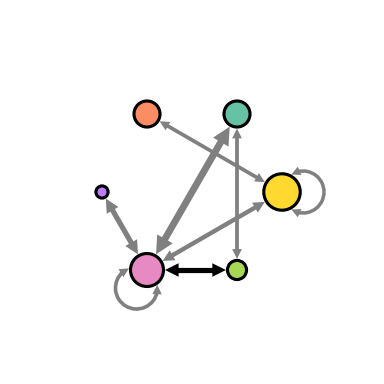

In [103]:
fig, axs = make_network_plots_polygon(m=m, # Number of monomers
                                        n_input=num_inputs, # Number of inputs
                                        param_sets=param_sets, # Parameter sets to draw from
                                        univs_to_plot=np.array([0]), # Indicies of param_sets to plot
                                        dimers_of_interest=dimers_of_interest, # Index of output dimer
                                        input_node_values=input_node_values, # Abundances to use for input node(s), log scale
                                        ncols = 1, # Number of columns in figure
                                        r_node = r_node, # Radius of nodes around center
                                        r_loop = r_loop, # Radius of loops around nodes 
                                        node_scales = node_scales, # Scales for node sizes (lower and upper bounds in log scale, min and max sizes)
                                        K_edge_scales = K_edge_scales, # Scales for edge widths (lower and upper bounds in log scale, min and max widths)
                                        input_cmap=modified_cmap, # Colormap for nodes
                                        fontname='Helvetica', # Font name
                                        fontsize=9, # Font size
                                        non_output_dimer_color='gray',
                                        labels=False,
                                        upscale_arrowhead=1.3,
                                        node_edge_width=node_edge_width,
)

fig.set_dpi(300)

if save:
    filename = f'Fig7A_{name}'
    plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),bbox_inches='tight',pad_inches=0,transparent=True)
    fig.patch.set_facecolor('white')
    plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight',pad_inches=0)

## Grayed Out Random Networks

In [25]:
m = 6
num_inputs = 2
name = f'{m}M_random'

rng = np.random.default_rng()

input_node_abundance = 1e0

lower_log_K = -2
upper_log_K = 2

### Generate:

In [166]:
# Affinities
num_dimers = int(num_combos_with_replacement(m,2))
dimer_names = make_nXn_species_names(m)[m::]
edge_key = {}
homo_edges = []
hetero_edges = []

for i,combo in enumerate(itertools.combinations_with_replacement(range(m),r=2)):
    edge_key[(combo[0],combo[1])] = i
    if combo[0]==combo[1]:
        homo_edges.append(i)
    else:
        hetero_edges.append(i)

# Generate initial K
K = 10**rng.uniform(-2,0,size=num_dimers)
K = np.full((num_dimers),1e-10)

# Choose how many heterodimer edges
desired_hetero_edges = int((0.3*num_dimers)//1)

# Generate connected graph that has desired_hetero_edges
graph = nx.gnm_random_graph(n=m,m=desired_hetero_edges) # Generate a Networkx graph
while not nx.is_connected(graph):
    graph = nx.gnm_random_graph(n=m,m=desired_hetero_edges)

edge_indices = [edge_key[x] for x in graph.edges]
K[edge_indices] = 10**rng.uniform(lower_log_K,upper_log_K,size=(desired_hetero_edges,))

# Choose how many homodimer edges (we'll also say no input homodimers, for aesthetic)
desired_homo_edges = 2
K[rng.choice(homo_edges[num_inputs:],size=desired_homo_edges,replace=False)] = 10**rng.uniform(lower_log_K,upper_log_K,size=(desired_homo_edges,))

###  Load 1 & 2:

In [73]:
m = 6
num_inputs = 2
name = f'{m}M_random_1'

rng = np.random.default_rng()

input_node_values=np.array([np.log10(input_node_abundance) for i in range(num_inputs)])

K = np.array([1e-10, 1.37902651e-02, 1e-10, 1e-10,
       1e-10, 1.32402163e-01, 1e-10, 1e-10,
       6.18613302e-01, 4.29983368e+01, 1e-10, 1e-10,
       1e-10, 6.70396132e+01, 1e-10, 1e-10,
       1e-10, 1e-10, 5.33026483e-02, 1.12067144e+01,
       4.84828469e-01])

In [78]:
m = 6
num_inputs = 2
name = f'{m}M_random_2'

rng = np.random.default_rng()

input_node_values=np.array([np.log10(input_node_abundance) for i in range(num_inputs)])

K = np.array([1e-10, 1e-10, 1.28066991e+01, 1.13834245e-02,
       1e-10, 1e-10, 1e-10, 1.37013719e-02,
       1e-10, 1.67319198e+00, 1e-10, 1e-10,
       1e-10, 1e-10, 1e-10, 1.33639857e+01,
       1.03648126e-01, 1e-10, 6.33879185e+01, 8.49870500e-01,
       1e-10])

In [79]:
# Accessory expression levels
A = np.full((m-num_inputs),input_node_abundance)
input_node_values=np.array([np.log10(input_node_abundance) for i in range(num_inputs)])

param_sets = np.expand_dims(np.hstack((K,A)),axis=0)

dimers_of_interest = None

# r_node = 0.15 # Radius of nodes around center
# r_loop = 0.04 # Radius of loops around nodes 
# node_scales = [-3,3,2,5] # Scales for node sizes (lower and upper bounds in log scale, min and max sizes)
# K_edge_scales = [-4,3,0.25,1.25] # Scales for edge widths (lower and upper bounds in log scale, min and max widths)
# node_edge_width = 0.5

r_node = 0.22 # Radius of nodes around center
r_loop = 0.05 # Radius of loops around nodes 
node_scales = [-3,3,2,8] # Scales for node sizes (lower and upper bounds in log scale, min and max sizes)
K_edge_scales = [-4,3,0.25,2] # Scales for edge widths (lower and upper bounds in log scale, min and max widths)
node_edge_width = 0.6

gray_level = 0.5 # 0 = black, 1 = white

###  Load 3 & 4:

In [83]:
m = 6
num_inputs = 2
name = f'{m}M_random_3'

rng = np.random.default_rng()

input_node_values=np.array([np.log10(input_node_abundance) for i in range(num_inputs)])

K = np.array([1e-10, 1e-10, 1.95565263e-01, 1e-10,
       1.54219856e+00, 1e-10, 1e-10, 8.33592790e-01,
       1e-10, 5.28608813e+00, 1e-10, 1e-10,
       6.51436487e+01, 1e-10, 2.36757151e-02, 1.59176643e+00,
       1e-10, 1e-10, 1e-10, 1e-10,
       3.87425873e+00])

In [88]:
m = 6
num_inputs = 2
name = f'{m}M_random_4'

rng = np.random.default_rng()

input_node_values=np.array([np.log10(input_node_abundance) for i in range(num_inputs)])

K = np.array([1e-10, 2.87802605e-01, 6.83258542e-01, 1e-10,
       4.57555752e-01, 1e-10, 1e-10, 1e-10,
       1.97001964e+00, 1e-10, 1e-10, 2.47716922e-01,
       4.96922419e+00, 1e-10, 1e-10, 2.06711253e-01,
       1e-10, 1.52990042e+01, 1e-10, 1e-10,
       1e-10])

In [89]:
# Accessory expression levels
A = np.full((m-num_inputs),input_node_abundance)
input_node_values=np.array([np.log10(input_node_abundance) for i in range(num_inputs)])

param_sets = np.expand_dims(np.hstack((K,A)),axis=0)

dimers_of_interest = None

# r_node = 0.11 # Radius of nodes around center
# r_loop = 0.03 # Radius of loops around nodes 
# node_scales = [-3,3,2,3] # Scales for node sizes (lower and upper bounds in log scale, min and max sizes)
# K_edge_scales = [-4,3,0.25,0.75] # Scales for edge widths (lower and upper bounds in log scale, min and max widths)
# node_edge_width = 0.3

r_node = 0.22 # Radius of nodes around center
r_loop = 0.05 # Radius of loops around nodes 
node_scales = [-3,3,2,8] # Scales for node sizes (lower and upper bounds in log scale, min and max sizes)
K_edge_scales = [-4,3,0.25,2] # Scales for edge widths (lower and upper bounds in log scale, min and max widths)
node_edge_width = 0.6

gray_level = 0.85 # 0 = black, 1 = white

## Plot

In [90]:
save = True

In [91]:
# gray_level = 0.6 # 0 = black, 1 = white
cmap_list = [tuple([gray_level for j in range(3)]) for i in range(m)]
allgray_cmap = mcolors.ListedColormap(cmap_list)

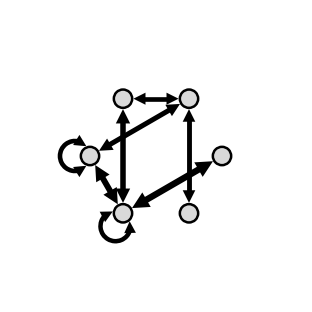

In [92]:
fig, axs = make_network_plots_polygon(m=m, # Number of monomers
                                        n_input=num_inputs, # Number of inputs
                                        param_sets=param_sets, # Parameter sets to draw from
                                        univs_to_plot=np.array([0]), # Indicies of param_sets to plot
                                        dimers_of_interest=dimers_of_interest, # Index of output dimer
                                        input_node_values=input_node_values, # Abundances to use for input node(s), log scale
                                        ncols = 1, # Number of columns in figure
                                        r_node = r_node, # Radius of nodes around center
                                        r_loop = r_loop, # Radius of loops around nodes 
                                        node_scales = node_scales, # Scales for node sizes (lower and upper bounds in log scale, min and max sizes)
                                        K_edge_scales = K_edge_scales, # Scales for edge widths (lower and upper bounds in log scale, min and max widths)
                                        input_cmap=allgray_cmap, # Colormap for nodes
                                        fontname='Helvetica', # Font name
                                        fontsize=9, # Font size
                                        non_output_dimer_color='gray',
                                        labels=False,
                                        upscale_arrowhead=1.3,
                                        node_edge_width=node_edge_width,
)

fig.set_dpi(300)

if save:
    filename = f'Fig7A_{name}'
    plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),bbox_inches='tight',pad_inches=0,transparent=True)
    # fig.patch.set_facecolor('white')
    plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=5000,bbox_inches='tight',pad_inches=0,transparent=True)